In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import scipy.constants as const
import pandas as pd
from scipy.stats import norm
from scipy.integrate import trapz

# Soil Calculations

In order to calculate the fraction of the soil made up of various radioactive components, the following equation was used:

\begin{align*}
    \dot{N} &= \lambda N \\
    &= \lambda \frac{m_{Isotope} A_v}{m_{Molar}} \\
    & \rightarrow \\
    m_{Isotope} &= \frac{t_{1/2} m_{Molar} \dot{N}}{\ln{\left( 2 \right)} A_v}
\end{align*}

For Uranium:

\begin{align*}
    \dot{N}_U = \ln{\left(2\right)} \left[ \frac{f m_U A_v}{\left( t_{1/2}  m_{Molar} \right)_{235}} + \frac{\left( 1-f \right) m_U A_v}{\left( t_{1/2}  m_{Molar} \right)_{238}} \right]
\end{align*}

Where $f$ is the mass enrichment fraction (0.7% for natural Uranium)

In [2]:
def soil_comp(half_life, molar_mass, activity):
    num = half_life * molar_mass * activity
    den = np.log(2) * const.Avogadro * 1000.
    
    return num / den

In [3]:
soil_isotopes = pd.DataFrame(
    [
        ['Cs-137', 30.05, 136.907, 200e-12 * 3.7e10],
        ['K-40', 1.251e9, 39.96399848, 370],
        ['Th-232', 1.405e10, 232.0380553, 35]
    ],
    columns=[
        'Isotope',
        'Half Life',
        'Molar Mass',
        'Activity'
    ]
)

In [4]:
soil_isotopes['Mass/kg soil'] = soil_comp(
    soil_isotopes['Half Life'] * 365.241 * 24 * 60 * 60,
    soil_isotopes['Molar Mass'],
    soil_isotopes['Activity']
)

In [5]:
m_M_25 = 235.0439299
m_M_28 = 238.0507882

t_25 = 7.04e8 * 365.241 * 24 * 60 * 60
t_28 = 4.468e9 * 365.241 * 24 * 60 * 60

AV = const.Avogadro

f = 0.007

A_U = 35

m_U = 1e-3 / ((AV * np.log(2) / A_U) * (f / (t_25 * m_M_25) + (1 - f)/(t_28 * m_M_28)))
print("Uranium Mass (per kg):\t{0}".format(m_U))
print("U-235 Mass (per kg):\t{0}".format(m_U * f))
print("U-238 Mass (per kg):\t{0}".format(m_U * (1 - f)))

Uranium Mass (per kg):	2.71126930474e-06
U-235 Mass (per kg):	1.89788851332e-08
U-238 Mass (per kg):	2.69229041961e-06


In [6]:
soil_isotopes = soil_isotopes.append(pd.DataFrame(
    [
        ['U-235', t_25, m_M_25, np.NaN, 6.01419398082e-13],
        ['U-238', t_28, m_M_28, np.NaN, 8.53156374707e-11]
    ],
    columns=[
        'Isotope',
        'Half Life',
        'Molar Mass',
        'Activity',
        'Mass/kg soil'
    ]
))

In [7]:
mass_soil = 700 * 700 * 30 * 1.82 / 1000
print("Soil Mass:\t{0}".format(mass_soil))

Soil Mass:	26754.0


In [8]:
soil_isotopes

,Isotope,Half Life,Molar Mass,Activity,Mass/kg soil
0,Cs-137,3.005000e+01,136.907000,7.4,2.301541e-15
1,K-40,1.251000e+09,39.963998,370.0,1.398443e-06
2,Th-232,1.405000e+10,232.038055,35.0,8.626218e-06
0,U-235,2.221600e+16,235.043930,NaN,6.014194e-13
1,U-238,1.409959e+17,238.050788,NaN,8.531564e-11


In [9]:
specific_activity_soil = 2.99e2 # photon/second/kg
time = 10 # seconds
activity = specific_activity_soil * time *  mass_soil
print("Photons in 10s from soil:\t{0}".format(activity))

Photons in 10s from soil:	79994460.0


# MCNP Results

In [10]:
bkg_mean = 2583.82 # From F8 tally of Bkg.o
src_plus_bkg_mean = 2769.38 # From F8 tally of Bkg
bkg_sigma = 4 * bkg_mean ** 0.5
src_plus_bkg_sigma = 4 * src_plus_bkg_mean ** 0.5
print("Background:\t\t{0} +/- {1}".format(bkg_mean, bkg_sigma))
print("Source plus Background\t{0} +/- {1}".format(src_plus_bkg_mean, 
                                                   src_plus_bkg_sigma))

Background:		2583.82 +/- 203.325158306
Source plus Background	2769.38 +/- 210.499596199


# ROC Curve

## Notes
- I originally defined a function to generate a normal/Gaussian distribution: $$ P(x) = \frac{1}{\sqrt{2 \pi \sigma^2}} \mathrm{e}^{-\frac{\left( x - \mu \right)^2}{2 \sigma^2}} $$, but found that the function built into the SciPy library was more performant. A similar result was found for the CDF (when generating the ROC curve).
- Similarly, rather than perform the numerical integration with a self-built function, the SciPy function "trapz" was used.

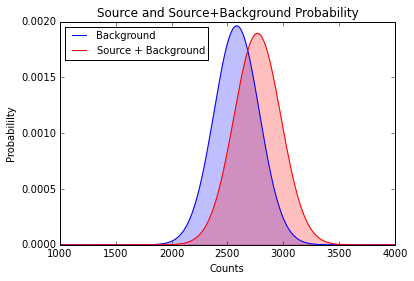

In [11]:
x = np.linspace(1000, 4000, 3000)

plt.plot(x, norm.pdf(x, loc=bkg_mean, scale=bkg_sigma), color='b', label="Background")
plt.fill(x, norm.pdf(x, loc=bkg_mean, scale=bkg_sigma), color='b', alpha=0.25)
plt.plot(x, norm.pdf(x, loc=src_plus_bkg_mean, scale=src_plus_bkg_sigma), 
         color='r', label="Source + Background")
plt.fill(x, norm.pdf(x, loc=src_plus_bkg_mean, scale=src_plus_bkg_sigma), 
         color='r', alpha=0.25)

plt.ylabel("Probabililty")
plt.xlabel("Counts")
plt.title("Source and Source+Background Probability")

plt.legend(loc="upper left", fontsize=10)

plt.show()

In [12]:
def rocval(threshold, bkg_mean=bkg_mean, 
           bkg_sigma=bkg_sigma, 
           src_plus_bkg_mean=src_plus_bkg_mean, 
           src_plus_bkg_sigma=src_plus_bkg_sigma):
    falsepos = 1 - norm.cdf(
        threshold, 
        loc=bkg_mean, 
        scale=bkg_sigma
    )
    truepos = 1 - norm.cdf(
        threshold, 
        loc=src_plus_bkg_mean, 
        scale=src_plus_bkg_sigma
    )
    return falsepos, truepos

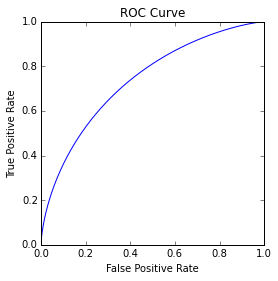

In [13]:
plt.plot([rocval(t)[0] for t in range(4000)], 
         [rocval(t)[1] for t in range(4000)])
plt.title("ROC Curve")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.axes().set_aspect('equal')
plt.show()

# Area Under the Curve

In [14]:
trapz([rocval(t)[1] for t in range(4000)][::-1], 
      x=[rocval(t)[0] for t in range(4000)][::-1])

0.73697270560359263

The area under the curve for this detector is $0.737$. 